In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from safe_control_gym.lyapunov.lyapunov import *
from safe_control_gym.lyapunov.utilities import *
from safe_control_gym.experiments.arxiv.utils.gpmpc_plotting_utils import *

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })

/home/tumeilsy-mo-10/anaconda3/envs/safe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print('notebook_dir', notebook_dir)
data_folder = '../data/cartpole_constraint/'
data_folder_path = os.path.join(notebook_dir, data_folder)
print('data_folder_path', data_folder_path)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
s = 2 # times of std

notebook_dir /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_constraint/utils
data_folder_path /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_constraint/utils/../data/cartpole_constraint/


In [3]:
class benchmark_constraint_data:
    # data stored in the path like "prior/seed/figs/"
    # each data is a csv file
    def __init__(self, data_folder_path, controller_name, prior_name):
        self.data_folder_path = data_folder_path
        self.controller_name = controller_name
        self.prior_name = prior_name
        self.controller_data_folder_path = os.path.join(data_folder_path, controller_name)
        self.prior_data_folder_path = os.path.join(self.controller_data_folder_path, prior_name)
        self.none_count = 0
        self.early_stop = 0
        self.max_seed = None
        self.check_data_folder()
        self.find_all_seed_folders()
        self.append_figs_to_seeds()
        self.load_csv_peak_viol_theta_data_all_seeds()
        self.load_csv_peak_viol_theta_dot_data_all_seeds()
        self.load_num_violations_all_seeds()
        self.early_stop_ratio = self.early_stop / self.max_seed

    def check_data_folder(self):
        if not os.path.exists(self.prior_data_folder_path):
            print('prior data folder does not exist')
            return False
        print(f'prior data {self.prior_name} folder exists')
        return True
    
    def find_all_seed_folders(self):
        # find all folder name in the prior data folder
        self.seed_folders = [f for f in os.listdir(self.prior_data_folder_path) \
                        if os.path.isdir(os.path.join(self.prior_data_folder_path, f))]
        # get the number between 'seed' and '_'
        seed_list = [int(f.split('seed')[1].split('_')[0]) for f in self.seed_folders]
        sorted_seed_folders = [x for _, x in sorted(zip(seed_list, self.seed_folders))]
        self.seed_folders = sorted_seed_folders
        self.max_seed = np.max(seed_list)
        print('max seed', self.max_seed)
    
    def append_figs_to_seeds(self):
        # append 'figs' to the end of seed_folders
        self.seed_folders = [os.path.join(self.prior_data_folder_path, f) for f in self.seed_folders]
        self.seed_folders = [os.path.join(f, 'figs') for f in self.seed_folders]
    
    def load_csv_peak_viol_theta_data(self, seed):
        # load the csv file in the seed folder
        # return the data in the csv file
        seed_folder = self.seed_folders[seed-1]
        csv_file = os.path.join(seed_folder, 'peak_viol_theta.csv')
        # if the file does not exist, return None
        if not os.path.exists(csv_file):
            print(f'csv file for seed {seed} does not exist')
            self.none_count += 1
            return None
        data = np.genfromtxt(csv_file, delimiter=',')
        return data
    
    def load_csv_peak_viol_theta_dot_data(self, seed):
        # load the csv file in the seed folder
        # return the data in the csv file
        seed_folder = self.seed_folders[seed-1]
        csv_file = os.path.join(seed_folder, 'peak_viol.csv')
        # if the file does not exist, return None
        if not os.path.exists(csv_file):
            print(f'csv file for seed {seed} does not exist')
            self.none_count += 1
            return None
        data = np.genfromtxt(csv_file, delimiter=',')
        return data
    
    def load_csv_peak_viol_theta_data_all_seeds(self):
        # load all csv files in the seed folders
        # return the data in the csv files
        self.data_all_seeds = []
        for seed in range(len(self.seed_folders)):
            data = self.load_csv_peak_viol_theta_data(seed)
            self.data_all_seeds.append(data)
        all_epoch = [0 for _ in range(len(self.seed_folders))]
        for data in self.data_all_seeds:
            if data is not None:
                all_epoch.append(data.shape[0])
        self.sim_epoch = np.max(all_epoch)
        print('sim_epoch', self.sim_epoch)
        for i, data in enumerate(self.data_all_seeds):
            if data is not None:
                if data.shape[0] < self.sim_epoch:
                    self.early_stop += 1
                    print(f'seed {i} early stop with epoch {data.shape[0]}')
            elif data is None:
                self.early_stop += 1
                print(f'seed {i} early stop with epoch 0')
        # pop out the data with None and early stop
        self.merged_data_theta = []
        for data in self.data_all_seeds:
            if data is not None and data.shape[0] == self.sim_epoch:
                self.merged_data_theta.append(data)
    
    def load_csv_peak_viol_theta_dot_data_all_seeds(self):
        # load all csv files in the seed folders
        # return the data in the csv files
        self.data_all_seeds = []
        for seed in range(len(self.seed_folders)):
            data = self.load_csv_peak_viol_theta_dot_data(seed)
            self.data_all_seeds.append(data)
        all_epoch = [0 for _ in range(len(self.seed_folders))]
        for data in self.data_all_seeds:
            if data is not None:
                all_epoch.append(data.shape[0])
        self.sim_epoch = np.max(all_epoch)
        print('sim_epoch', self.sim_epoch)
        for i, data in enumerate(self.data_all_seeds):
            if data is not None:
                if data.shape[0] < self.sim_epoch:
                    self.early_stop += 1
                    print(f'seed {i} early stop with epoch {data.shape[0]}')
            elif data is None:
                self.early_stop += 1
                print(f'seed {i} early stop with epoch 0')
        # pop out the data with None and early stop
        self.merged_data_theta_dot = []
        for data in self.data_all_seeds:
            if data is not None and data.shape[0] == self.sim_epoch:
                self.merged_data_theta_dot.append(data)

    def load_num_violations(self, seed):
        seed_folder = self.seed_folders[seed-1]
        csv_file = os.path.join(seed_folder, 'number_viol.csv')
        if not os.path.exists(csv_file):
            print(f'csv file for seed {seed} does not exist')
            self.none_count += 1
            return None
        data = np.genfromtxt(csv_file, delimiter=',')
        data = data[:, :2]
        return data
    
    def load_num_violations_all_seeds(self):
        self.data_all_seeds = []
        for seed in range(len(self.seed_folders)):
            data = self.load_num_violations(seed)
            self.data_all_seeds.append(data)
        all_epoch = [0 for _ in range(len(self.seed_folders))]
        for data in self.data_all_seeds:
            if data is not None:
                all_epoch.append(data.shape[0])
        self.sim_epoch = np.max(all_epoch)
        print('sim_epoch', self.sim_epoch)
        for i, data in enumerate(self.data_all_seeds):
            if data is not None:
                if data.shape[0] < self.sim_epoch:
                    self.early_stop += 1
                    print(f'seed {i} early stop with epoch {data.shape[0]}')
            elif data is None:
                self.early_stop += 1
                print(f'seed {i} early stop with epoch 0')
        # pop out the data with None and early stop
        self.merged_data_num_viol = []
        for data in self.data_all_seeds:
            if data is not None and data.shape[0] == self.sim_epoch:
                self.merged_data_num_viol.append(data)
        

    def get_mean_std_peak_viol_theta(self):
        # get the mean and std of the data
        self.mean_data_theta = np.mean(self.merged_data_theta, axis=0)
        self.std_data_theta = np.std(self.merged_data_theta, axis=0)
        # round the first column of mean to integer
        self.mean_data_theta[:, 0] = np.round(self.mean_data_theta[:, 0])
        # leave out the first colum of the std
        self.std_data_theta = self.std_data_theta[:, 1:]
        self.std_data_theta = self.std_data_theta.squeeze()
        return self.mean_data_theta, self.std_data_theta
    
    def get_mean_std_peak_viol_theta_dot(self):
        # get the mean and std of the data
        self.mean_data_theta_dot = np.mean(self.merged_data_theta_dot, axis=0)
        self.std_data_theta_dot = np.std(self.merged_data_theta_dot, axis=0)
        # round the first column of mean to integer
        self.mean_data_theta_dot[:, 0] = np.round(self.mean_data_theta_dot[:, 0])
        # leave out the first colum of the std
        self.std_data_theta_dot = self.std_data_theta_dot[:, 1:]
        self.std_data_theta_dot = self.std_data_theta_dot.squeeze()
        return self.mean_data_theta_dot, self.std_data_theta_dot

    def get_mean_std_num_violations(self):
        # get the mean and std of the data
        self.mean_data_num_viol = np.mean(self.merged_data_num_viol, axis=0)
        self.std_data_num_viol = np.std(self.merged_data_num_viol, axis=0)
        # round the first column of mean to integer
        self.mean_data_num_viol[:, 0] = np.round(self.mean_data_num_viol[:, 0])
        # leave out the first colum of the std
        self.std_data_num_viol = self.std_data_num_viol[:, 1:]
        self.std_data_num_viol = self.std_data_num_viol.squeeze()
        return self.mean_data_num_viol, self.std_data_num_viol

    # def load_csv_cost_data(self, seed):
    #     # load the csv file in the seed folder
    #     # return the data in the csv file
    #     seed_folder = self.seed_folders[seed-1]
    #     csv_file = os.path.join(seed_folder, 'common_cost_learning_curve.csv')
    #     # if the file does not exist, return None
    #     if not os.path.exists(csv_file):
    #         print(f'csv file for seed {seed} does not exist')
    #         self.none_count += 1
    #         return None
    #     data = np.genfromtxt(csv_file, delimiter=',')
    #     return data

    # def load_csv_cost_data_all_seeds(self):
    #     # load all csv files in the seed folders
    #     # return the data in the csv files
    #     self.data_all_seeds = []
    #     for seed in range(len(self.seed_folders)):
    #         data = self.load_csv_cost_data(seed)
    #         self.data_all_seeds.append(data)
    #     all_epoch = [0 for _ in range(len(self.seed_folders))]
    #     for data in self.data_all_seeds:
    #         if data is not None:
    #             all_epoch.append(data.shape[0])
    #     self.sim_epoch = np.max(all_epoch)
    #     print('sim_epoch', self.sim_epoch)
    #     for i, data in enumerate(self.data_all_seeds):
    #         if data is not None:
    #             if data.shape[0] < self.sim_epoch:
    #                 self.early_stop += 1
    #                 print(f'seed {i} early stop with epoch {data.shape[0]}')
    #         elif data is None:
    #             self.early_stop += 1
    #             print(f'seed {i} early stop with epoch 0')
    #     # pop out the data with None and early stop
    #     self.merged_data = []
    #     for data in self.data_all_seeds:
    #         if data is not None and data.shape[0] == self.sim_epoch:
    #             self.merged_data.append(data)
        
    # def get_mean_std(self):
    #     # get the mean and std of the data
    #     self.mean_data = np.mean(self.merged_data, axis=0)
    #     self.std_data = np.std(self.merged_data, axis=0)
    #     # round the first column of mean to integer
    #     self.mean_data[:, 0] = np.round(self.mean_data[:, 0])
    #     # leave out the first colum of the std
    #     self.std_data = self.std_data[:, 1:]
    #     self.std_data = self.std_data.squeeze()
    #     return self.mean_data, self.std_data
        

In [14]:
controller_name = 'gp_mpc'
# get the default pyplot color cycle

prior_list = [
              'M_0.1',
              'M_0.5', 
              'M_1.0', 
              'M_1.5', 
              'M_2.0', 
              'M_3.0',
              'M_3.0_hpo'
              ]
# prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_constraint_data(data_folder_path, controller_name, prior)
    data_list.append(data)


M_500 = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_0.5')
M_100 = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_1.0')
M_2000 = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_2.0')
M_3000 = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_3.0')
M_1500 = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_1.5')
M_1000 = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_1.0')
M_3000_hpo = benchmark_constraint_data(data_folder_path, 'gp_mpc', 'M_3.0_hpo')
    
# test_data = M_500.load_num_violations(1)
# print('test_data', test_data)
# # print('test_data', test_data)
# mean, std = M_500.get_mean_std()
# print('mean', mean)
# print('std', std)
# print('none count', M_500.none_count)


prior data M_0.1 folder exists
max seed 15
csv file for seed 10 does not exist
sim_epoch 6
seed 0 early stop with epoch 2
seed 6 early stop with epoch 3
seed 7 early stop with epoch 2
seed 8 early stop with epoch 2
seed 9 early stop with epoch 2
seed 10 early stop with epoch 0
seed 11 early stop with epoch 2
seed 13 early stop with epoch 2
csv file for seed 10 does not exist
sim_epoch 6
seed 0 early stop with epoch 2
seed 6 early stop with epoch 3
seed 7 early stop with epoch 2
seed 8 early stop with epoch 2
seed 9 early stop with epoch 2
seed 10 early stop with epoch 0
seed 11 early stop with epoch 2
seed 13 early stop with epoch 2
csv file for seed 10 does not exist
sim_epoch 6
seed 0 early stop with epoch 2
seed 6 early stop with epoch 3
seed 7 early stop with epoch 2
seed 8 early stop with epoch 2
seed 9 early stop with epoch 2
seed 10 early stop with epoch 0
seed 11 early stop with epoch 2
seed 13 early stop with epoch 2
prior data M_0.5 folder exists
max seed 15
sim_epoch 6
sim_e

Text(0.5, 1.0, 'Cartpole GP-MPC Cost Learning Curve')

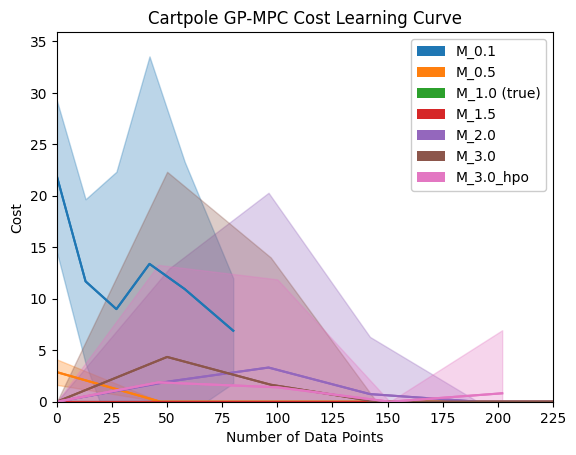

In [12]:
# plot the mean and std

for i, data in enumerate(data_list):
    mean, std = data.get_mean_std_peak_viol_theta()
    plt.plot(mean[:, 0], mean[:, 1], label=prior_list[i], color=colors[i])
    plt.plot(mean[:, 0], mean[:, 1], color=colors[i])
    plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                     color=colors[i])
# create the legend for each prior
ax = plt.gca()
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]   
for i in range(len(prior_list)):
    if prior_list[i] == 'M_1.0':
        prior_list[i] = 'M_1.0 (true)'
legend = ax.legend(proxy, prior_list, loc='upper right')
legend.get_frame().set_alpha(1.)
# limit the y axis to 0- 100
plt.ylim(0, None)
plt.xlim(0, 225)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole GP-MPC Cost Learning Curve')
# use log y scale
# ax.set_yscale('log')

# plt.legend()

Text(0.5, 1.0, 'Cartpole GP-MPC Cost Learning Curve')

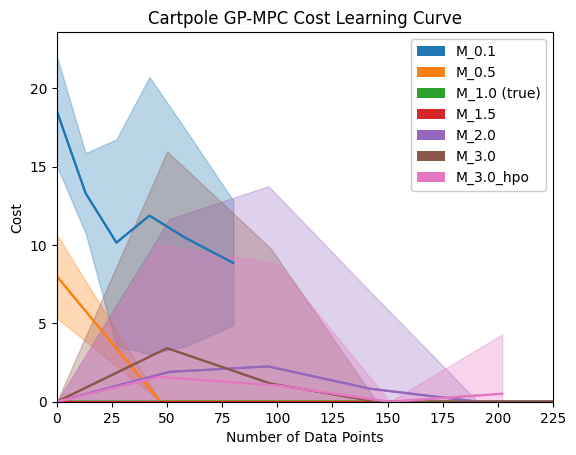

In [13]:
# plot the mean and std

for i, data in enumerate(data_list):
    mean, std = data.get_mean_std_peak_viol_theta_dot()
    plt.plot(mean[:, 0], mean[:, 1], label=prior_list[i], color=colors[i])
    plt.plot(mean[:, 0], mean[:, 1], color=colors[i])
    plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                     color=colors[i])
# create the legend for each prior
ax = plt.gca()
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]   
for i in range(len(prior_list)):
    if prior_list[i] == 'M_1.0':
        prior_list[i] = 'M_1.0 (true)'
legend = ax.legend(proxy, prior_list, loc='upper right')
legend.get_frame().set_alpha(1.)
# limit the y axis to 0- 100
plt.ylim(0, None)
plt.xlim(0, 225)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole GP-MPC Cost Learning Curve')
# use log y scale
# ax.set_yscale('log')

# plt.legend()

Text(0.5, 1.0, 'Cartpole GP-MPC Cost Learning Curve')

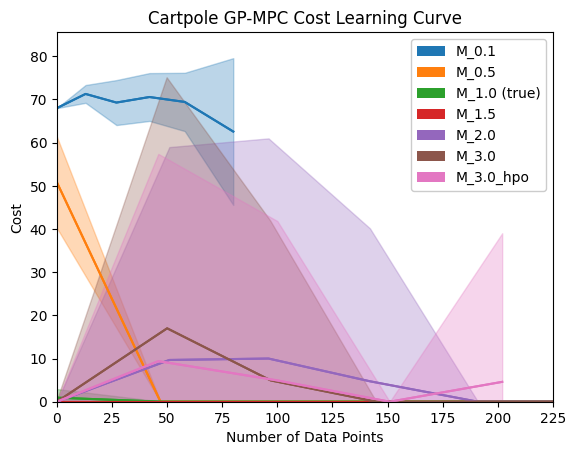

In [15]:
# plot the mean and std

for i, data in enumerate(data_list):
    mean, std = data.get_mean_std_num_violations()
    plt.plot(mean[:, 0], mean[:, 1], label=prior_list[i], color=colors[i])
    plt.plot(mean[:, 0], mean[:, 1], color=colors[i])
    plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                     color=colors[i])
# create the legend for each prior
ax = plt.gca()
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]   
for i in range(len(prior_list)):
    if prior_list[i] == 'M_1.0':
        prior_list[i] = 'M_1.0 (true)'
legend = ax.legend(proxy, prior_list, loc='upper right')
legend.get_frame().set_alpha(1.)
# limit the y axis to 0- 100
plt.ylim(0, None)
plt.xlim(0, 225)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole GP-MPC Cost Learning Curve')
# use log y scale
# ax.set_yscale('log')

# plt.legend()

yticks [  0.  20.  40.  60.  80. 100.]
yticks [  0.  25.  50.  75. 100. 125.]


/tmp/ipykernel_62181/1574481948.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)


[Text(0, 0.0, '0.0'),
 Text(0, 20.0, '25.0'),
 Text(0, 40.0, '50.0'),
 Text(0, 60.0, '75.0'),
 Text(0, 80.0, '100.0'),
 Text(0, 100.0, '125.0')]

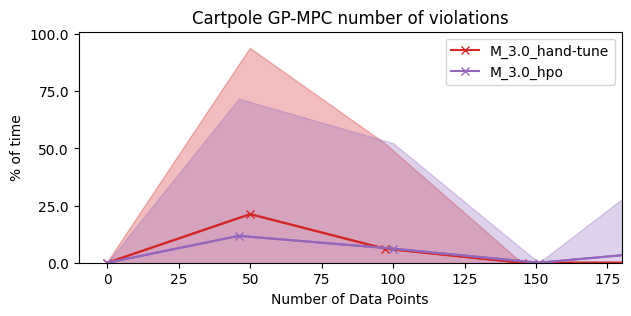

In [19]:
fig = plt.figure(figsize=(8, 3))

# mean, std = M_500.get_mean_std_num_violations()
# plt.plot(mean[:, 0], mean[:, 1], label='M_0.5', color=colors[0], marker='o')
# plt.plot(mean[:, 0], mean[:, 1], color=colors[0])
# plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                  color=colors[0])
# mean, std = M_1000.get_mean_std_num_violations()
# plt.plot(mean[:, 0], mean[:, 1], label='M_1.0 (true)', color=colors[1], linestyle='-.')
# plt.plot(mean[:, 0], mean[:, 1], color=colors[1])
# plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                  color=colors[1])
# mean, std = M_1500.get_mean_std_num_violations()
# plt.plot(mean[:, 0], mean[:, 1], label='M_1.5', color=colors[2], marker='*')
# plt.plot(mean[:, 0], mean[:, 1], color=colors[2])
# plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                  color=colors[2])
mean, std = M_3000.get_mean_std_num_violations()
plt.plot(mean[:, 0], mean[:, 1], label='M_3.0_hand-tune', color=colors[3], marker='x')
plt.plot(mean[:, 0], mean[:, 1], color=colors[3])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[3])
mean, std = M_3000_hpo.get_mean_std_num_violations()
plt.plot(mean[:, 0], mean[:, 1], label='M_3.0_hpo', color=colors[4], marker='x')
plt.plot(mean[:, 0], mean[:, 1], color=colors[4])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[4])

ax = plt.gca()
# limit the y axis to 0- 100
# plt.ylim(0, None)

plt.ylim(0, None)
plt.xlim(-10, 180)
plt.xlabel('Number of Data Points')
plt.ylabel('% of time')
plt.title('Cartpole GP-MPC number of violations')
plt.legend()
# change the plot ratio to 4:3
ax.set_aspect(aspect=1.0)

# set the y ticks values to be its original value/75
yticks = ax.get_yticks()
print('yticks', yticks)
yticks = yticks/80 * 100 # * 1.9
print('yticks', yticks)
# round the yticks to 2 decimal
yticks = np.round(yticks, 2)
ax.set_yticklabels(yticks)


Text(0.5, 1.0, 'Cartpole GP-MPC Max Violation $\\dot{\\theta}$')

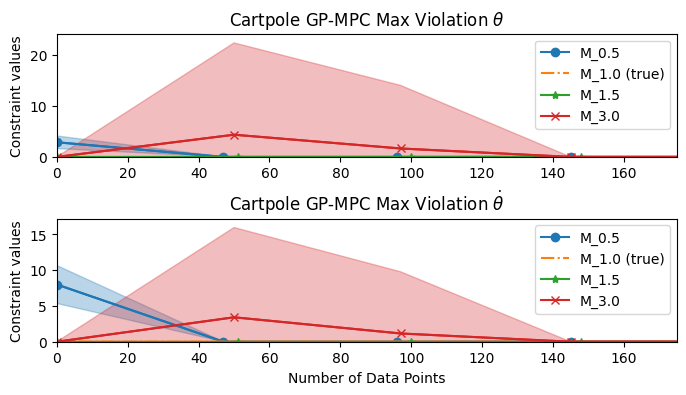

In [9]:
# plot the max violation theta and theta dot on subplots, and align the x axis

fig, ax = plt.subplots(2, 1, figsize=(8, 4))



mean, std = M_500.get_mean_std_peak_viol_theta()
ax[0].plot(mean[:, 0], mean[:, 1], label='M_0.5', color=colors[0], marker='o')
ax[0].plot(mean[:, 0], mean[:, 1], color=colors[0])
ax[0].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[0])
mean, std = M_1000.get_mean_std_peak_viol_theta()
ax[0].plot(mean[:, 0], mean[:, 1], label='M_1.0 (true)', color=colors[1], linestyle='-.')
ax[0].plot(mean[:, 0], mean[:, 1], color=colors[1])
ax[0].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[1])
mean, std = M_1500.get_mean_std_peak_viol_theta()
ax[0].plot(mean[:, 0], mean[:, 1], label='M_1.5', color=colors[2], marker='*')
ax[0].plot(mean[:, 0], mean[:, 1], color=colors[2])
ax[0].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[2])
mean, std = M_3000.get_mean_std_peak_viol_theta()
ax[0].plot(mean[:, 0], mean[:, 1], label='M_3.0', color=colors[3], marker='x')
ax[0].plot(mean[:, 0], mean[:, 1], color=colors[3])
ax[0].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[3])
# create the legend for each prior
ax[0].legend()
# limit the y axis to 0- 100
ax[0].set_ylim(0, None)
ax[0].set_xlim(0, 175)
ax[0].set_ylabel('Constraint values')
ax[0].set_title(r'Cartpole GP-MPC Max Violation $\theta$')
# set space between subplots
plt.subplots_adjust(hspace=0.5)

mean, std = M_500.get_mean_std_peak_viol_theta_dot()
ax[1].plot(mean[:, 0], mean[:, 1], label='M_0.5', color=colors[0], marker='o')
ax[1].plot(mean[:, 0], mean[:, 1], color=colors[0])
ax[1].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[0])
mean, std = M_1000.get_mean_std_peak_viol_theta_dot()
ax[1].plot(mean[:, 0], mean[:, 1], label='M_1.0 (true)', color=colors[1], linestyle='-.')
ax[1].plot(mean[:, 0], mean[:, 1], color=colors[1])
ax[1].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[1])
mean, std = M_1500.get_mean_std_peak_viol_theta_dot()
ax[1].plot(mean[:, 0], mean[:, 1], label='M_1.5', color=colors[2], marker='*')
ax[1].plot(mean[:, 0], mean[:, 1], color=colors[2])
ax[1].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[2])
mean, std = M_3000.get_mean_std_peak_viol_theta_dot()
ax[1].plot(mean[:, 0], mean[:, 1], label='M_3.0', color=colors[3], marker='x')
ax[1].plot(mean[:, 0], mean[:, 1], color=colors[3])
ax[1].fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[3])
# create the legend for each prior
ax[1].legend()
# limit the y axis to 0- 100
ax[1].set_ylim(0, None)
ax[1].set_xlim(0, 175)
ax[1].set_xlabel('Number of Data Points')
ax[1].set_ylabel('Constraint values')
ax[1].set_title(r'Cartpole GP-MPC Max Violation $\dot{\theta}$')




In [10]:
# save the cost mean and std to npy file
mean, std = M_500.get_mean_std()
data_amount = mean[:, 0]
mean = mean[:, 1]


data = {'mean': mean, 'std': std, 'data_amount': data_amount}
data_file_name = 'gp_mpc_M_0.5_cost.npy'
data_file_path = os.path.join(data_folder_path, data_file_name)
np.save(data_file_path, data)
print(f'save data to {data_file_path}')

mean, std = M_1000.get_mean_std()
data_amount = mean[:, 0]
mean = mean[:, 1]
data = {'mean': mean, 'std': std, 'data_amount': data_amount}
data_file_name = 'gp_mpc_M_1.0_cost.npy'
data_file_path = os.path.join(data_folder_path, data_file_name)
np.save(data_file_path, data)
print(f'save data to {data_file_path}')

mean, std = M_3000.get_mean_std()
data_amount = mean[:, 0]
mean = mean[:, 1]

data = {'mean': mean, 'std': std, 'data_amount': data_amount}
data_file_name = 'gp_mpc_M_3.0_cost.npy'
data_file_path = os.path.join(data_folder_path, data_file_name)
np.save(data_file_path, data)

print(f'save data to {data_file_path}')




AttributeError: 'benchmark_constraint_data' object has no attribute 'get_mean_std'

prior data M_0.1 folder exists
max seed 15
csv file for seed 2 does not exist
csv file for seed 3 does not exist
csv file for seed 4 does not exist
csv file for seed 6 does not exist
csv file for seed 7 does not exist
csv file for seed 8 does not exist
csv file for seed 9 does not exist
csv file for seed 10 does not exist
csv file for seed 12 does not exist
csv file for seed 13 does not exist
sim_epoch 6
seed 0 early stop with epoch 2
seed 2 early stop with epoch 0
seed 3 early stop with epoch 0
seed 4 early stop with epoch 0
seed 5 early stop with epoch 2
seed 6 early stop with epoch 0
seed 7 early stop with epoch 0
seed 8 early stop with epoch 0
seed 9 early stop with epoch 0
seed 10 early stop with epoch 0
seed 11 early stop with epoch 2
seed 12 early stop with epoch 0
seed 13 early stop with epoch 0
seed 14 early stop with epoch 4
prior data M_0.5 folder exists
max seed 15
csv file for seed 7 does not exist
csv file for seed 14 does not exist
sim_epoch 6
seed 1 early stop with epoc

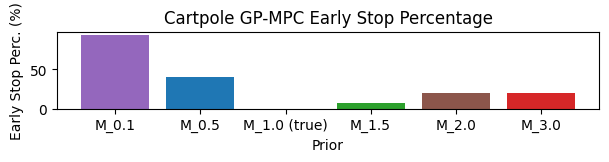

In [ ]:
# plot the early stop percentage
plt.figure(figsize=(7, 1))
max_seed = M_500.max_seed


# prior_list = ['M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_3.0']
# for i, data in enumerate(data_list):
#     print(f'prior {prior_list[i]} early stop percentage: {data.early_stop_ratio}')
#     plt.bar(prior_list[i], data.early_stop_ratio * 100, color=colors[i])

# prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_cost_data(data_folder_path, controller_name, prior)
    data_list.append(data)
prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
plt.bar(prior_list[0], data_list[0].early_stop_ratio * 100, color=colors[4]) # M_0.1
plt.bar(prior_list[1], data_list[1].early_stop_ratio * 100, color=colors[0]) # M_0.5
plt.bar(prior_list[2], data_list[2].early_stop_ratio * 100, color=colors[1]) # M_1.0
plt.bar(prior_list[3], data_list[3].early_stop_ratio * 100, color=colors[2]) # M_1.5
plt.bar(prior_list[4], data_list[4].early_stop_ratio * 100, color=colors[5]) # M_2.0
plt.bar(prior_list[5], data_list[5].early_stop_ratio * 100, color=colors[3]) # M_3.0
plt.xlabel('Prior')
plt.ylabel('Early Stop Perc. (%)')
plt.title('Cartpole GP-MPC Early Stop Percentage')

ax=plt.gca()
# change the plot ratio to 4:3
# ax.set_aspect(aspect=3.0)
# save the figure
plt.savefig('cartpole_gp_mpc_early_stop.png', dpi=300)




In [ ]:
controller_name = 'sqp_gp_mpc'
# get the default pyplot color cycle

prior_list = [
                'M_0.1',
                'M_0.5', 
                'M_1.0', 
                'M_1.5', 
                'M_2.0', 
                'M_3.0']
# prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_cost_data(data_folder_path, controller_name, prior)
    data_list.append(data)

# M_100 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_0.1')
M_500 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_0.5')
M_1000 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_1.0')
M_1500 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_1.5')
M_2000 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_2.0')
# M_2500 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_2.5')
M_3000 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_3.0')

# plot the mean and std

for i, data in enumerate(data_list):
    mean, std = data.get_mean_std()
    plt.plot(mean[:, 0], mean[:, 1], label=prior_list[i], color=colors[i])
    plt.plot(mean[:, 0], mean[:, 1], color=colors[i])
    plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                     color=colors[i])
    
# create the legend for each prior
ax = plt.gca()
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]
for i in range(len(prior_list)):
    if prior_list[i] == 'M_1.0':
        prior_list[i] = 'M_1.0 (true)'
legend = ax.legend(proxy, prior_list, loc='upper right')
legend.get_frame().set_alpha(1.)
# limit the y axis to 0- 100
plt.ylim(0, None)
plt.xlim(0, 180)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole SQP-GP-MPC Cost Learning Curve')
# use log y scale
# ax.set_yscale('log')

# plt.legend()


prior data folder does not exist


FileNotFoundError: [Errno 2] No such file or directory: '/home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/sqp_gp_mpc/M_0.1'

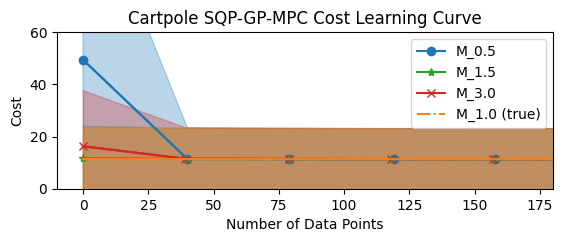

In [ ]:
mean, std = M_500.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_0.5', color=colors[0], marker='o')
plt.plot(mean[:, 0], mean[:, 1], color=colors[0])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[0])
mean, std = M_1500.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_1.5', color=colors[2], marker='*')
plt.plot(mean[:, 0], mean[:, 1], color=colors[2])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[2])
mean, std = M_3000.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_3.0', color=colors[3], marker='x')
plt.plot(mean[:, 0], mean[:, 1], color=colors[3])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[3])
mean, std = M_1000.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_1.0 (true)', color=colors[1], linestyle='-.')
plt.plot(mean[:, 0], mean[:, 1], color=colors[1])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[1])

ax = plt.gca()
# limit the y axis to 0- 100
# plt.ylim(0, None)
plt.ylim(0, 60)
plt.xlim(-10, 180)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole SQP-GP-MPC Cost Learning Curve')
plt.legend()

# change the plot ratio to 4:3
ax.set_aspect(aspect=1.0)

prior data M_0.1 folder exists
max seed 15
csv file for seed 2 does not exist
csv file for seed 3 does not exist
csv file for seed 4 does not exist
csv file for seed 7 does not exist
csv file for seed 8 does not exist
csv file for seed 13 does not exist
csv file for seed 14 does not exist
sim_epoch 6
seed 2 early stop with epoch 0
seed 3 early stop with epoch 0
seed 4 early stop with epoch 0
seed 7 early stop with epoch 0
seed 8 early stop with epoch 0
seed 13 early stop with epoch 0
seed 14 early stop with epoch 0
prior data M_0.5 folder exists
max seed 15
sim_epoch 6
prior data M_1.0 folder exists
max seed 15
sim_epoch 6
prior data M_1.5 folder exists
max seed 15
sim_epoch 6
prior data M_2.0 folder exists
max seed 15
sim_epoch 6
prior data M_3.0 folder exists
max seed 15
sim_epoch 6


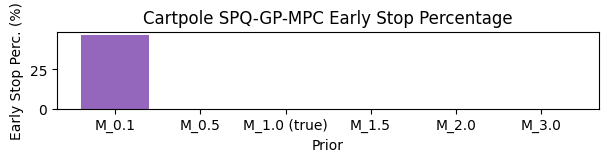

In [ ]:
# plot the early stop percentage
plt.figure(figsize=(7, 1))
max_seed = M_500.max_seed


# prior_list = ['M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_3.0']
# for i, data in enumerate(data_list):
#     print(f'prior {prior_list[i]} early stop percentage: {data.early_stop_ratio}')
#     plt.bar(prior_list[i], data.early_stop_ratio * 100, color=colors[i])

# prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_cost_data(data_folder_path, controller_name, prior)
    data_list.append(data)
prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
plt.bar(prior_list[0], data_list[0].early_stop_ratio * 100, color=colors[4]) # M_0.1
plt.bar(prior_list[1], data_list[1].early_stop_ratio * 100, color=colors[0]) # M_0.5
plt.bar(prior_list[2], data_list[2].early_stop_ratio * 100, color=colors[1]) # M_1.0
plt.bar(prior_list[3], data_list[3].early_stop_ratio * 100, color=colors[2]) # M_1.5
plt.bar(prior_list[4], data_list[4].early_stop_ratio * 100, color=colors[5]) # M_2.0
plt.bar(prior_list[5], data_list[5].early_stop_ratio * 100, color=colors[3]) # M_3.0
plt.xlabel('Prior')
plt.ylabel('Early Stop Perc. (%)')
plt.title('Cartpole SPQ-GP-MPC Early Stop Percentage')

ax=plt.gca()
# change the plot ratio to 4:3
# ax.set_aspect(aspect=3.0)
# save the figure
plt.savefig('cartpole_gp_mpc_early_stop.png', dpi=300)
